# Pauta L01 - IIC2115
__________

In [1]:
import math 
import comodoro as C
import sys
from copy import copy, deepcopy 

class Edificacion:
    
    def __init__(self):
        self.turnos_restantes = 0
        
    def generar_viaje(self):
        p = C.uniforme(0,1)
        if p <= 0.25: #auto
            return 1
        elif 0.25 < p <= 0.75 : #bus
            return 2
        elif 0.75 < p <= 0.9: #caminata
            return 3
        else: #bicicleta
            return 4 

    def get_proximo_viaje(self, lam):
        self.turnos_restantes -= 1
        ret = []
        while self.turnos_restantes < 0:
            ret.append(self.generar_viaje())
            self.turnos_restantes += C.exponencial(lam)
        return ret

class Hogar(Edificacion):
    
    def __init__(self):
        super().__init__()
        self.cantidad_personas = 0
        self.turnos_restantes = C.exponencial(2)
        
    
    def proximo_viaje(self):
        return self.get_proximo_viaje(2)

class Oficina(Edificacion):
    
    def __init__(self):
        super().__init__()
        self.cantidad_personas = 0
        self.turnos_restantes = C.exponencial(3)
    
    def proximo_viaje(self):
        return self.get_proximo_viaje(3)

class Vialidad:
    
    def __init__(self):
        self.modos_de_transportes = []
        self.turnos_restantes = C.exponencial(1)
        
    @property    
    def cantidad_personas(self):
        n = 0
        for v in self.modos_de_transportes:
            n += v.capacidad
        return n

    def generar_viaje(self):
        p = C.uniforme(0,1)
        if p <= 0.25: #auto
            return 1
        elif 0.25 < p <= 0.75 : #bus
            return 2
        elif 0.75 < p <= 0.9: #caminata
            return 3
        else: #bicicleta
            return 4 
        
    def proximo_viaje(self):
        self.turnos_restantes -= 1
        ret = []
        while self.turnos_restantes < 0:
            ret.append(self.generar_viaje())
            self.turnos_restantes += C.exponencial(1)
        return ret


class Camino(Vialidad):
    
    def __init__(self):
        super().__init__()
        
class Calle(Vialidad):
    
    def __init__(self):
        super().__init__()
        
class Autopista(Vialidad):
    
    def __init__(self):
        super().__init__()

class Modo:    
    pid = 0
    def __init__(self, capacidad):
        self.pid = Modo.pid
        Modo.pid += 1
        self.capacidad = capacidad
        self.terminado = False
        self.velocidad = 0
        self.movidas = 0
        self.mov_anterior = None
        self.nombre = ''

    def mover(self, x_i, y_i, turno, mapa, otro):
        pos_mov = {"a": (1, 0), "b": (-1, 0), "d": (0, 1), "i": (0, -1)}
        if turno < self.movidas:
            return x_i, y_i
        
        self.movidas += 1

        i = x_i
        j = y_i
        for _ in range(self.velocidad):
            try:
                if isinstance(mapa[i+1][j], Vialidad):
                    a = True
                else:
                    a = False
            except:
                a = False
            try:
                if isinstance(mapa[i-1][j], Vialidad):
                    b = True
                else:
                    b = False
            except:
                b = False
            try:
                if isinstance(mapa[i][j+1], Vialidad):
                    d = True
                else:
                    d = False
            except:
                d = False
            try:
                if isinstance(mapa[i][j-1], Vialidad):
                    ii = True
                else:
                    ii = False
            except:
                ii = False
                
            if self.mov_anterior == 'a' and a:
                mov = 'a'
            elif self.mov_anterior == 'b' and b:
                mov = 'b'
            elif self.mov_anterior == 'i' and ii:
                mov = 'i'
            elif self.mov_anterior == 'd' and d:
                mov = 'd'
            else:
                mov = C.ruta(a, b, ii, d)

            self.mov_anterior = mov
            
            add_i, add_j = pos_mov[mov]

            i += add_i
            j += add_j

            if i in [0, len(mapa)-1] or j in [0, len(mapa[0])-1]:
                return i, j
        return i, j

class Auto(Modo):
    
    def __init__(self):
        super().__init__(round(C.uniforme(1,5)))
        self.nombre = 'Auto'
        
    def set_velocidad(self, id_vialidad):
        if id_vialidad == 2: # camino
            self.velocidad = 3
        elif id_vialidad == 3: # calle
            self.velocidad = 5
        elif id_vialidad == 4: # autopista
            self.velocidad = 7
    

class Bus(Modo):
    
    def __init__(self):
        super().__init__(round(C.uniforme(1,40)))
        self.nombre = 'Bus'

        
    def set_velocidad(self, id_vialidad):
        if id_vialidad == 2:
            self.velocidad = 2
        elif id_vialidad == 3:
            self.velocidad = 4
        elif id_vialidad == 4:
            self.velocidad = 5
            

class Bicicleta(Modo):
    
    def __init__(self):
        super().__init__(round(C.uniforme(1,2)))
        self.nombre = 'Bicicleta'
        
    def set_velocidad(self, id_vialidad):
        if id_vialidad == 2:
            self.velocidad = 2
        elif id_vialidad == 3:
            self.velocidad = 3
        elif id_vialidad == 4:
            self.velocidad = 3
            
class Caminata(Modo):
    
    def __init__(self):
        super().__init__(round(C.uniforme(1,1)))
        self.nombre = 'Caminata'
        
    def set_velocidad(self, id_vialidad):
        self.velocidad = 1


#simulamos creando una clase llamada simulación, la cual tiene dentro de sus métodos simular(no shit sherlock)
class Simulacion():
    
    def __init__(self):
        n_mapa = 1
        self.mapa = C.generar_mapa(n_mapa)
        self.iteraciones_simulacion = 4
        self.mapa_trabajo = []
        self.hogares = []
        self.oficinas = []
        
    def poblar_mapa(self):
        for i in range(len(self.mapa)):
            aux = []
            for j in range(len(self.mapa[i])):
                k = self.mapa[i][j]
                if k == 0:
                    aux.append(Hogar())
                    self.hogares.append((i,j))
                elif k == 1:
                    aux.append(Oficina())
                    self.oficinas.append((i,j))
                elif k == 2:
                    aux.append(Camino())
                elif k == 3:
                    aux.append(Calle())
                elif k == 4:
                    aux.append(Autopista())
                else:
                    aux.append((' '))
            self.mapa_trabajo.append(aux)

    def get_nuevo_transporte(self, tipo):
        if tipo == 1: # auto
            return Auto()
        elif tipo == 2: # bus
            return Bus()        
        elif tipo == 3: #caminata 
            return Caminata()
        elif tipo == 4: # bicicleta
            return Bicicleta()

    def revisar_posicion_por_viaje(self, i, j):
        if self.mapa_trabajo[i][j] != " ":
            nuevos_viajes = self.mapa_trabajo[i][j].proximo_viaje()  #reviso si hay nuevo viaje, lista de modos de transporte a agregar
            for tipo in nuevos_viajes:
                for x, y in [(i+1, j), (i-1, j), (i, j-1), (i, j+1)]: #reviso las cuatro posiciones adjacentes
                    try:
                        if self.mapa[x][y] in [2,3,4]: #si son camino, calle, autopista
                            self.mapa_trabajo[x][y].modos_de_transportes.append(self.get_nuevo_transporte(tipo)) # las agrego al espacio adecuado
                            print('Se ha creado un nuevo viaje en la posicion ({},{}), del tipo {}, con {} pasajeros'.format(x, y, self.mapa_trabajo[x][y].modos_de_transportes[-1].nombre, self.mapa_trabajo[x][y].modos_de_transportes[-1].capacidad))
                    except IndexError:
                        continue

    def revisar_nuevos_viajes(self):
        for i, j in self.hogares + self.oficinas:
            self.revisar_posicion_por_viaje(i, j)
        i = 0
        for j in range(len(self.mapa[0])):
            self.revisar_posicion_por_viaje(i, j)
        i = len(self.mapa)-1
        for j in range(len(self.mapa[0])):
            self.revisar_posicion_por_viaje(i, j)
        j = 0
        for i in range(len(self.mapa)):
            self.revisar_posicion_por_viaje(i, j)
        j = len(self.mapa[0])-1
        for i in range(len(self.mapa)):
            self.revisar_posicion_por_viaje(i, j)
        
    @property
    def population_map(self):
        m = []
        for i in range(len(self.mapa_trabajo)):
            aux = []
            for j in range(len(self.mapa_trabajo[i])):
                if isinstance(self.mapa_trabajo[i][j], Vialidad):
                    aux.append(self.mapa_trabajo[i][j].cantidad_personas)
                else:
                    aux.append(0)
            m.append(aux)
        return m

    def mover(self, turno):
        for i in range(len(self.mapa_trabajo)): # reviso las filas
            for j in range(len(self.mapa_trabajo[i])): # reviso a las columnas
                if isinstance(self.mapa_trabajo[i][j], Vialidad): # reviso si es una calle
                    for k in range(len(self.mapa_trabajo[i][j].modos_de_transportes)-1, -1, -1): # reviso los medios de transporte en esa posicion
                        vehiculo = self.mapa_trabajo[i][j].modos_de_transportes.pop(k) # extraigo el vehiculo
                        vehiculo.set_velocidad(self.mapa[i][j]) # le doy la nueva velocidad
                        new_i, new_j = vehiculo.mover(i, j, turno, self.mapa_trabajo, self.mapa) # le pido su nueva posicion
                        if new_i == 0 or new_i == len(self.mapa)-1:
                            continue
                        elif new_j == 0 or new_j == len(self.mapa[0])-1:
                            continue
                        else:
                            self.mapa_trabajo[new_i][new_j].modos_de_transportes.append(vehiculo) # lo pongo en su nueva posicion
                        

    def simular(self):
        self.poblar_mapa()
        for i in range(self.iteraciones_simulacion):
            print('PASAJEROS EN RUTA:', sum([sum(x) for x in self.population_map]), "\t TURNO:", i+1)
            self.revisar_nuevos_viajes()   
            C.imprimir_mapa(self.population_map, self.mapa)
            self.mover(i)
        print('SE HA TERMINADO LA CREACION DE VIAJES')
        turno = self.iteraciones_simulacion
        while sum([sum(x) for x in self.population_map]) > 0:
            print('PASAJEROS RESTANTES:', sum([sum(x) for x in self.population_map]), "\t TURNO:", turno+1)
            C.imprimir_mapa(self.population_map, self.mapa)
            self.mover(turno)
            turno += 1
        print("SIMULACION TERMINADA EN {} ITERACIONES".format(turno))
        C.imprimir_mapa(self.population_map, self.mapa)

PASAJEROS EN RUTA: 0 	 TURNO: 1
Se ha creado un nuevo viaje en la posicion (3,23), del tipo Auto, con 3 pasajeros
Se ha creado un nuevo viaje en la posicion (5,27), del tipo Bus, con 2 pasajeros
Se ha creado un nuevo viaje en la posicion (6,18), del tipo Bus, con 35 pasajeros
Se ha creado un nuevo viaje en la posicion (6,20), del tipo Bus, con 20 pasajeros
Se ha creado un nuevo viaje en la posicion (9,18), del tipo Bus, con 15 pasajeros
Se ha creado un nuevo viaje en la posicion (9,20), del tipo Bus, con 28 pasajeros
Se ha creado un nuevo viaje en la posicion (9,18), del tipo Bus, con 34 pasajeros
Se ha creado un nuevo viaje en la posicion (9,20), del tipo Bus, con 37 pasajeros
Se ha creado un nuevo viaje en la posicion (10,18), del tipo Bus, con 11 pasajeros
Se ha creado un nuevo viaje en la posicion (10,20), del tipo Bus, con 14 pasajeros
Se ha creado un nuevo viaje en la posicion (10,18), del tipo Auto, con 4 pasajeros
Se ha creado un nuevo viaje en la posicion (10,20), del tipo Aut

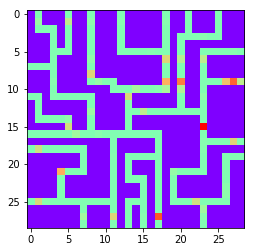

PASAJEROS EN RUTA: 841 	 TURNO: 2
Se ha creado un nuevo viaje en la posicion (3,23), del tipo Auto, con 4 pasajeros
Se ha creado un nuevo viaje en la posicion (5,18), del tipo Bus, con 35 pasajeros
Se ha creado un nuevo viaje en la posicion (5,20), del tipo Bus, con 33 pasajeros
Se ha creado un nuevo viaje en la posicion (6,18), del tipo Bus, con 23 pasajeros
Se ha creado un nuevo viaje en la posicion (6,20), del tipo Bus, con 9 pasajeros
Se ha creado un nuevo viaje en la posicion (6,18), del tipo Bicicleta, con 1 pasajeros
Se ha creado un nuevo viaje en la posicion (6,20), del tipo Bicicleta, con 1 pasajeros
Se ha creado un nuevo viaje en la posicion (7,18), del tipo Auto, con 2 pasajeros
Se ha creado un nuevo viaje en la posicion (7,20), del tipo Auto, con 3 pasajeros
Se ha creado un nuevo viaje en la posicion (7,18), del tipo Bus, con 10 pasajeros
Se ha creado un nuevo viaje en la posicion (7,20), del tipo Bus, con 37 pasajeros
Se ha creado un nuevo viaje en la posicion (9,18), del 

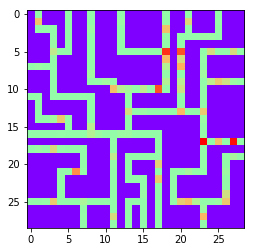

PASAJEROS EN RUTA: 1369 	 TURNO: 3
Se ha creado un nuevo viaje en la posicion (5,26), del tipo Bus, con 29 pasajeros
Se ha creado un nuevo viaje en la posicion (5,27), del tipo Auto, con 1 pasajeros
Se ha creado un nuevo viaje en la posicion (9,18), del tipo Bus, con 4 pasajeros
Se ha creado un nuevo viaje en la posicion (9,20), del tipo Bus, con 31 pasajeros
Se ha creado un nuevo viaje en la posicion (9,18), del tipo Auto, con 4 pasajeros
Se ha creado un nuevo viaje en la posicion (9,20), del tipo Auto, con 2 pasajeros
Se ha creado un nuevo viaje en la posicion (18,1), del tipo Auto, con 3 pasajeros
Se ha creado un nuevo viaje en la posicion (16,1), del tipo Auto, con 3 pasajeros
Se ha creado un nuevo viaje en la posicion (19,11), del tipo Auto, con 1 pasajeros
Se ha creado un nuevo viaje en la posicion (20,11), del tipo Caminata, con 1 pasajeros
Se ha creado un nuevo viaje en la posicion (22,11), del tipo Caminata, con 1 pasajeros
Se ha creado un nuevo viaje en la posicion (23,26), d

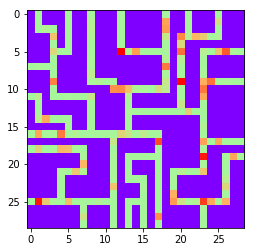

PASAJEROS EN RUTA: 1770 	 TURNO: 4
Se ha creado un nuevo viaje en la posicion (3,23), del tipo Bus, con 5 pasajeros
Se ha creado un nuevo viaje en la posicion (10,14), del tipo Bus, con 19 pasajeros
Se ha creado un nuevo viaje en la posicion (10,16), del tipo Auto, con 4 pasajeros
Se ha creado un nuevo viaje en la posicion (9,26), del tipo Bus, con 2 pasajeros
Se ha creado un nuevo viaje en la posicion (18,1), del tipo Bicicleta, con 2 pasajeros
Se ha creado un nuevo viaje en la posicion (16,1), del tipo Bicicleta, con 2 pasajeros
Se ha creado un nuevo viaje en la posicion (21,5), del tipo Auto, con 3 pasajeros
Se ha creado un nuevo viaje en la posicion (21,19), del tipo Bus, con 13 pasajeros
Se ha creado un nuevo viaje en la posicion (22,11), del tipo Caminata, con 1 pasajeros
Se ha creado un nuevo viaje en la posicion (23,26), del tipo Auto, con 4 pasajeros
Se ha creado un nuevo viaje en la posicion (25,3), del tipo Bus, con 38 pasajeros
Se ha creado un nuevo viaje en la posicion (25

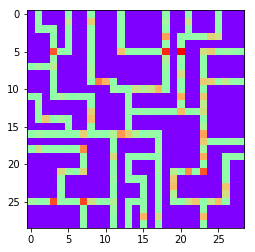

SE HA TERMINADO LA CREACION DE VIAJES
PASAJEROS RESTANTES: 2071 	 TURNO: 5


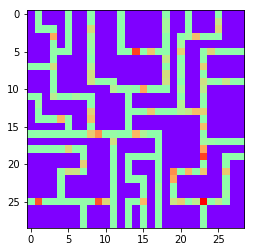

PASAJEROS RESTANTES: 1838 	 TURNO: 6


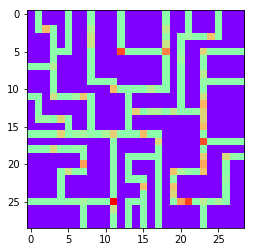

PASAJEROS RESTANTES: 1606 	 TURNO: 7


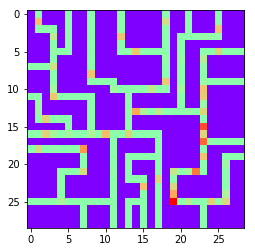

PASAJEROS RESTANTES: 1381 	 TURNO: 8


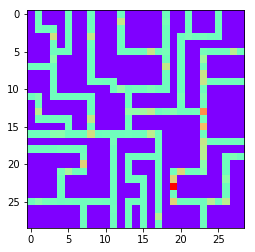

PASAJEROS RESTANTES: 1213 	 TURNO: 9


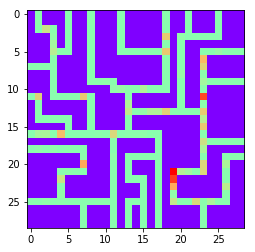

PASAJEROS RESTANTES: 1145 	 TURNO: 10


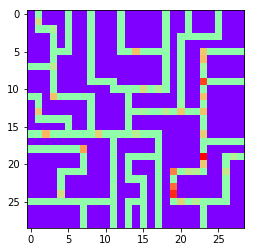

PASAJEROS RESTANTES: 1061 	 TURNO: 11


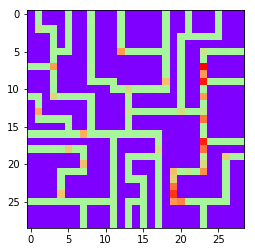

PASAJEROS RESTANTES: 1056 	 TURNO: 12


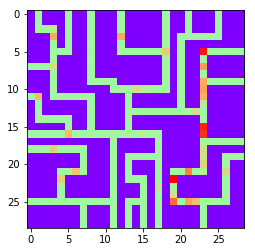

PASAJEROS RESTANTES: 1000 	 TURNO: 13


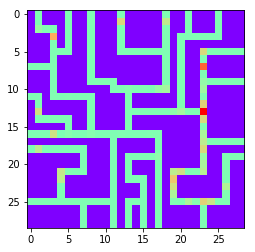

PASAJEROS RESTANTES: 914 	 TURNO: 14


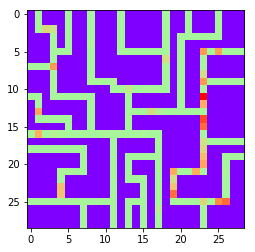

PASAJEROS RESTANTES: 876 	 TURNO: 15


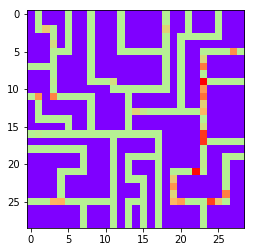

PASAJEROS RESTANTES: 793 	 TURNO: 16


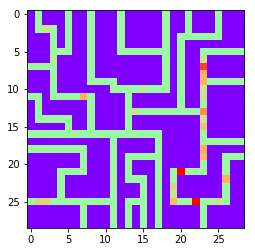

PASAJEROS RESTANTES: 744 	 TURNO: 17


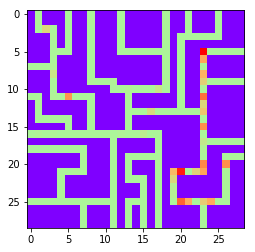

PASAJEROS RESTANTES: 741 	 TURNO: 18


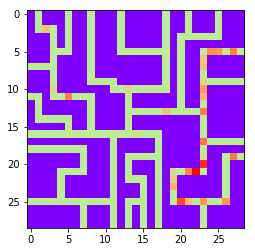

PASAJEROS RESTANTES: 664 	 TURNO: 19


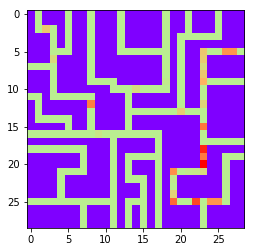

PASAJEROS RESTANTES: 603 	 TURNO: 20


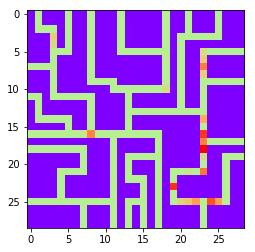

PASAJEROS RESTANTES: 602 	 TURNO: 21


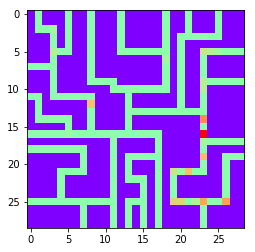

PASAJEROS RESTANTES: 599 	 TURNO: 22


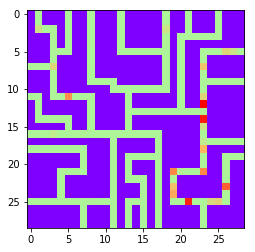

PASAJEROS RESTANTES: 555 	 TURNO: 23


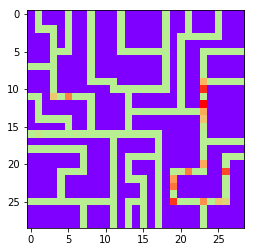

PASAJEROS RESTANTES: 550 	 TURNO: 24


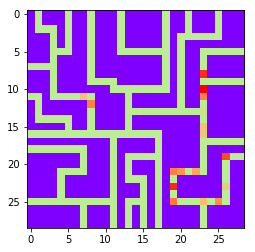

PASAJEROS RESTANTES: 501 	 TURNO: 25


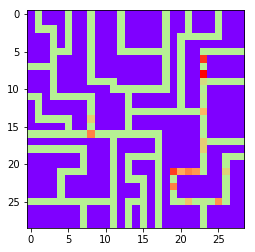

PASAJEROS RESTANTES: 499 	 TURNO: 26


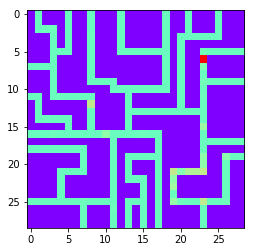

PASAJEROS RESTANTES: 499 	 TURNO: 27


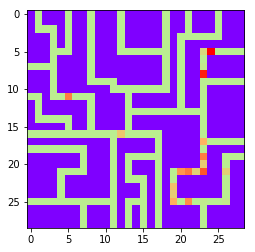

PASAJEROS RESTANTES: 498 	 TURNO: 28


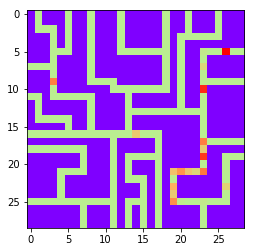

PASAJEROS RESTANTES: 433 	 TURNO: 29


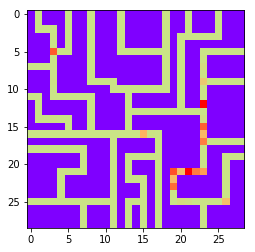

PASAJEROS RESTANTES: 433 	 TURNO: 30


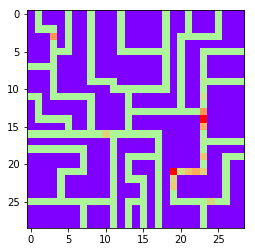

PASAJEROS RESTANTES: 433 	 TURNO: 31


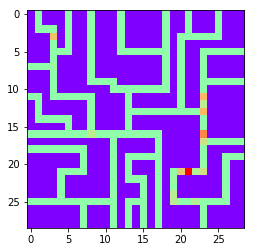

PASAJEROS RESTANTES: 433 	 TURNO: 32


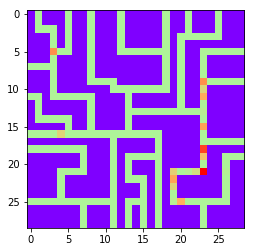

PASAJEROS RESTANTES: 433 	 TURNO: 33


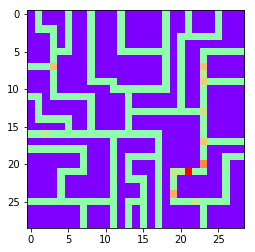

PASAJEROS RESTANTES: 417 	 TURNO: 34


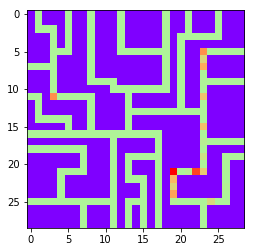

PASAJEROS RESTANTES: 417 	 TURNO: 35


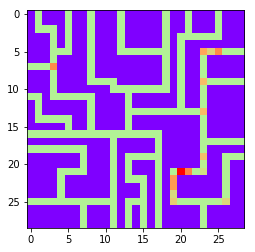

PASAJEROS RESTANTES: 417 	 TURNO: 36


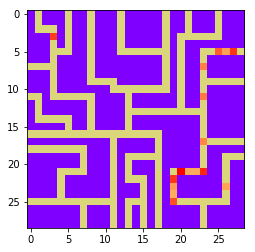

PASAJEROS RESTANTES: 365 	 TURNO: 37


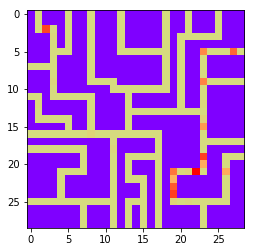

PASAJEROS RESTANTES: 336 	 TURNO: 38


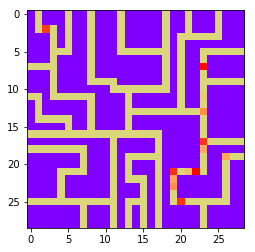

PASAJEROS RESTANTES: 322 	 TURNO: 39


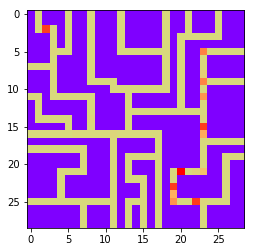

PASAJEROS RESTANTES: 322 	 TURNO: 40


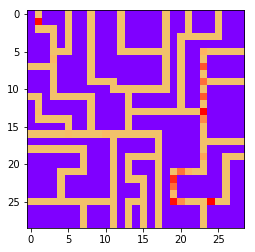

PASAJEROS RESTANTES: 286 	 TURNO: 41


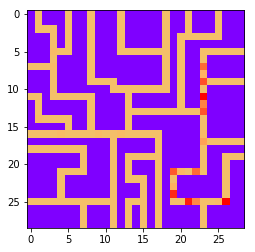

PASAJEROS RESTANTES: 286 	 TURNO: 42


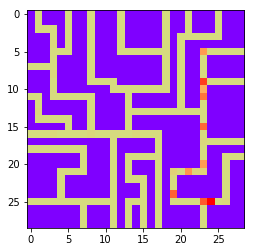

PASAJEROS RESTANTES: 286 	 TURNO: 43


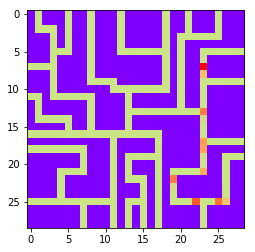

PASAJEROS RESTANTES: 286 	 TURNO: 44


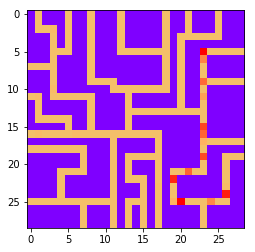

PASAJEROS RESTANTES: 283 	 TURNO: 45


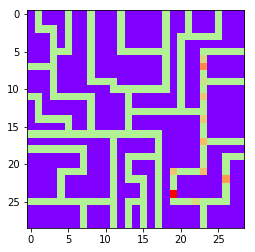

PASAJEROS RESTANTES: 283 	 TURNO: 46


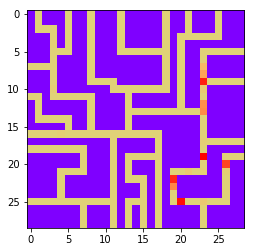

PASAJEROS RESTANTES: 283 	 TURNO: 47


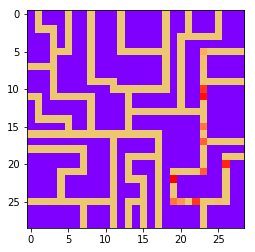

PASAJEROS RESTANTES: 283 	 TURNO: 48


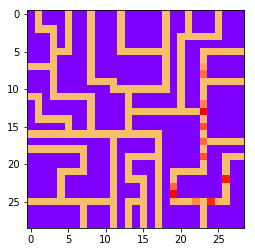

PASAJEROS RESTANTES: 281 	 TURNO: 49


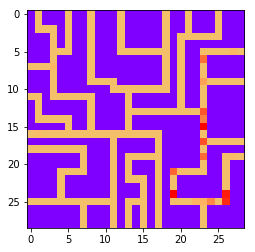

PASAJEROS RESTANTES: 277 	 TURNO: 50


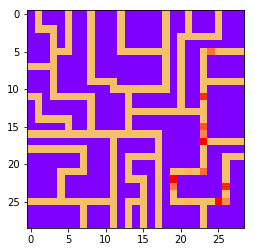

PASAJEROS RESTANTES: 277 	 TURNO: 51


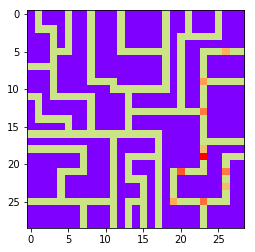

PASAJEROS RESTANTES: 260 	 TURNO: 52


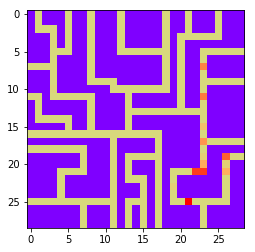

PASAJEROS RESTANTES: 257 	 TURNO: 53


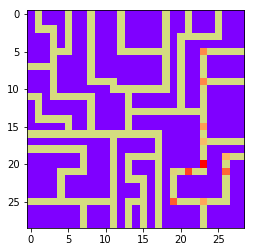

PASAJEROS RESTANTES: 257 	 TURNO: 54


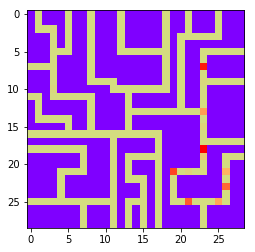

PASAJEROS RESTANTES: 257 	 TURNO: 55


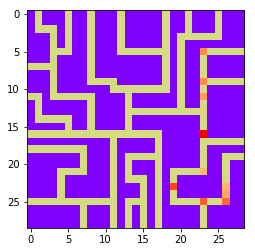

PASAJEROS RESTANTES: 257 	 TURNO: 56


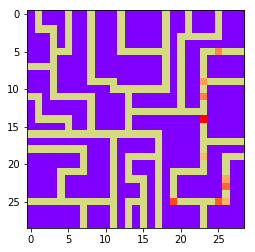

PASAJEROS RESTANTES: 257 	 TURNO: 57


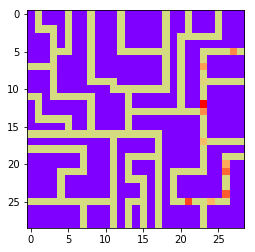

PASAJEROS RESTANTES: 233 	 TURNO: 58


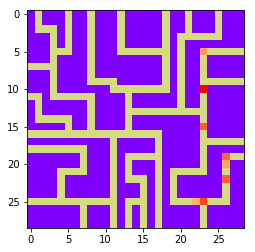

PASAJEROS RESTANTES: 203 	 TURNO: 59


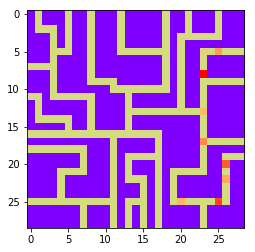

PASAJEROS RESTANTES: 203 	 TURNO: 60


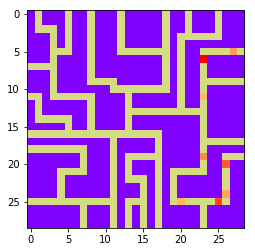

PASAJEROS RESTANTES: 185 	 TURNO: 61


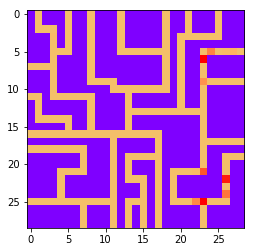

PASAJEROS RESTANTES: 182 	 TURNO: 62


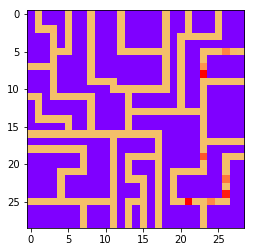

PASAJEROS RESTANTES: 168 	 TURNO: 63


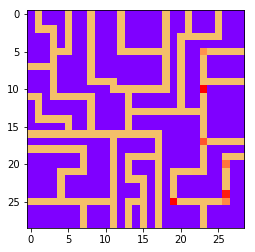

PASAJEROS RESTANTES: 168 	 TURNO: 64


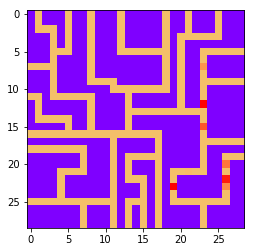

PASAJEROS RESTANTES: 168 	 TURNO: 65


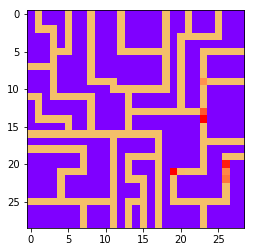

PASAJEROS RESTANTES: 168 	 TURNO: 66


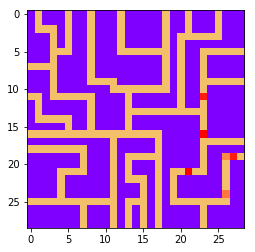

PASAJEROS RESTANTES: 124 	 TURNO: 67


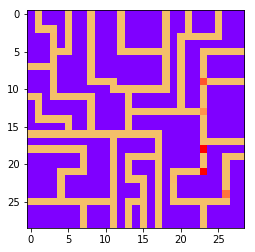

PASAJEROS RESTANTES: 124 	 TURNO: 68


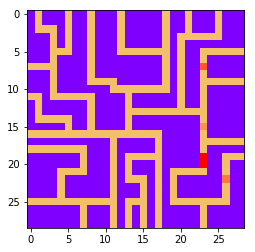

PASAJEROS RESTANTES: 124 	 TURNO: 69


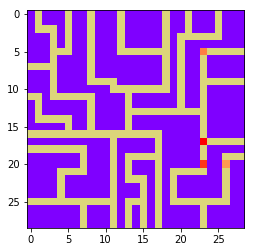

PASAJEROS RESTANTES: 124 	 TURNO: 70


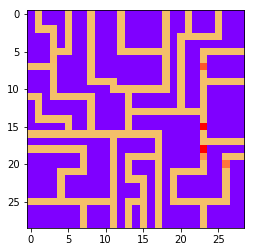

PASAJEROS RESTANTES: 124 	 TURNO: 71


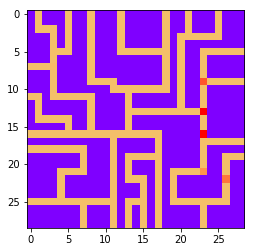

PASAJEROS RESTANTES: 124 	 TURNO: 72


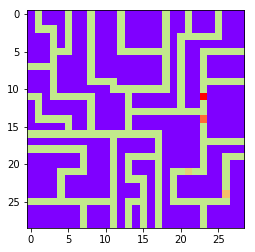

PASAJEROS RESTANTES: 124 	 TURNO: 73


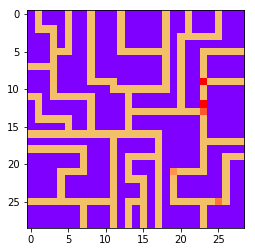

PASAJEROS RESTANTES: 124 	 TURNO: 74


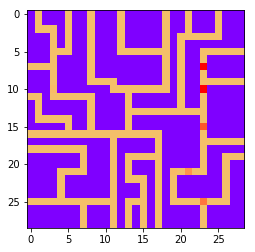

PASAJEROS RESTANTES: 124 	 TURNO: 75


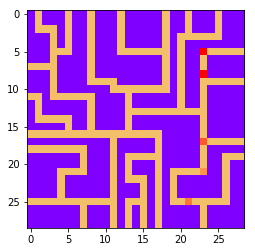

PASAJEROS RESTANTES: 124 	 TURNO: 76


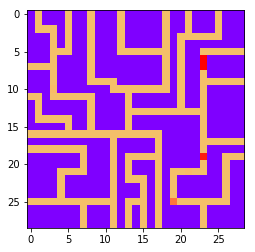

PASAJEROS RESTANTES: 124 	 TURNO: 77


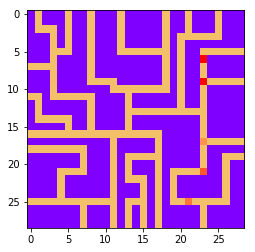

PASAJEROS RESTANTES: 124 	 TURNO: 78


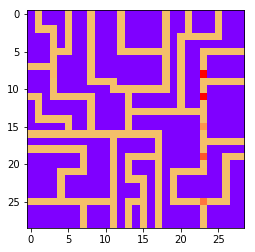

PASAJEROS RESTANTES: 124 	 TURNO: 79


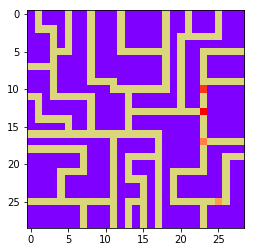

PASAJEROS RESTANTES: 124 	 TURNO: 80


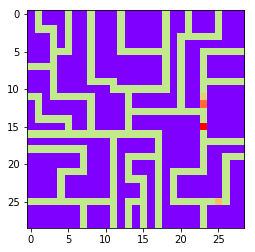

PASAJEROS RESTANTES: 124 	 TURNO: 81


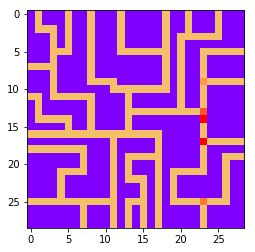

PASAJEROS RESTANTES: 124 	 TURNO: 82


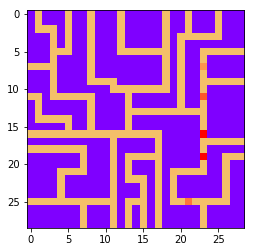

PASAJEROS RESTANTES: 124 	 TURNO: 83


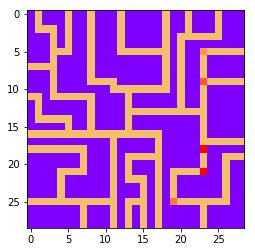

PASAJEROS RESTANTES: 124 	 TURNO: 84


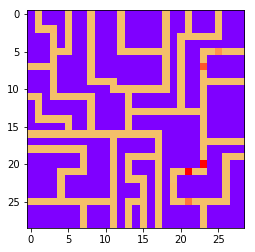

PASAJEROS RESTANTES: 124 	 TURNO: 85


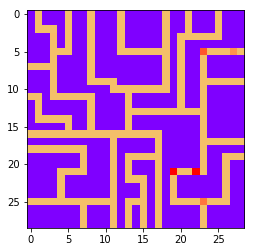

PASAJEROS RESTANTES: 114 	 TURNO: 86


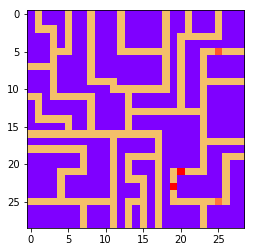

PASAJEROS RESTANTES: 114 	 TURNO: 87


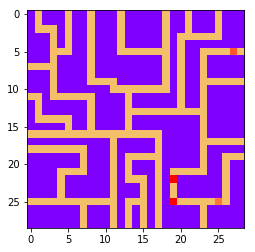

PASAJEROS RESTANTES: 92 	 TURNO: 88


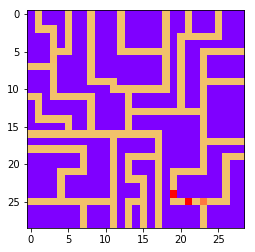

PASAJEROS RESTANTES: 92 	 TURNO: 89


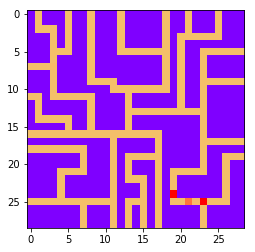

PASAJEROS RESTANTES: 92 	 TURNO: 90


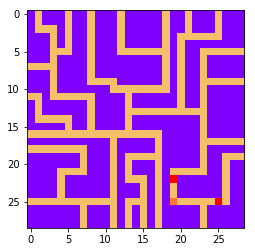

PASAJEROS RESTANTES: 92 	 TURNO: 91


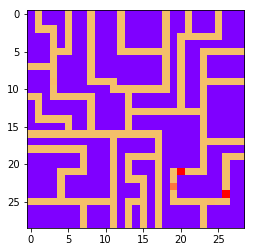

PASAJEROS RESTANTES: 92 	 TURNO: 92


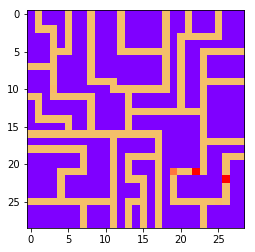

PASAJEROS RESTANTES: 92 	 TURNO: 93


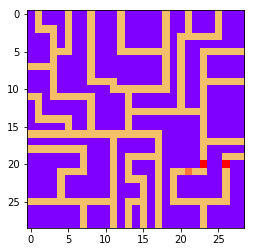

PASAJEROS RESTANTES: 92 	 TURNO: 94


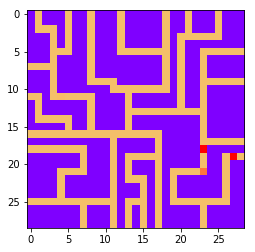

PASAJEROS RESTANTES: 55 	 TURNO: 95


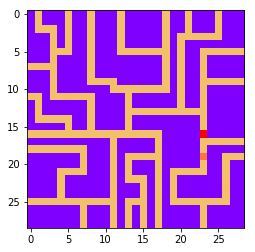

PASAJEROS RESTANTES: 55 	 TURNO: 96


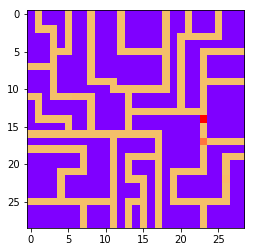

PASAJEROS RESTANTES: 55 	 TURNO: 97


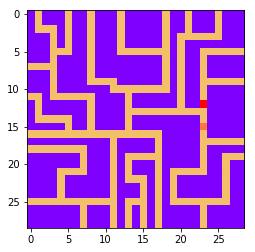

PASAJEROS RESTANTES: 55 	 TURNO: 98


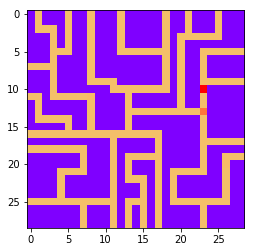

PASAJEROS RESTANTES: 55 	 TURNO: 99


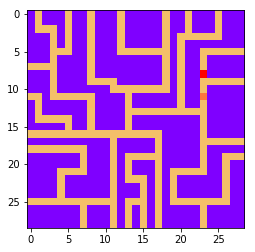

PASAJEROS RESTANTES: 55 	 TURNO: 100


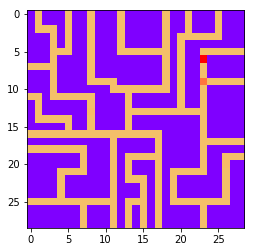

PASAJEROS RESTANTES: 55 	 TURNO: 101


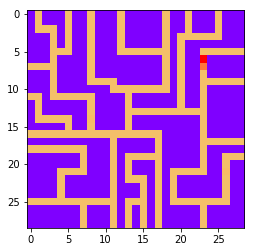

PASAJEROS RESTANTES: 55 	 TURNO: 102


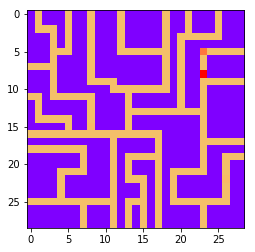

PASAJEROS RESTANTES: 55 	 TURNO: 103


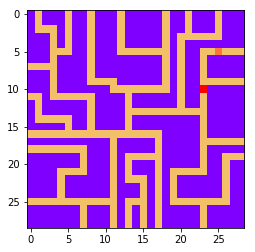

PASAJEROS RESTANTES: 55 	 TURNO: 104


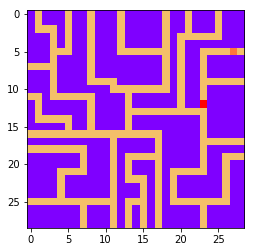

PASAJEROS RESTANTES: 39 	 TURNO: 105


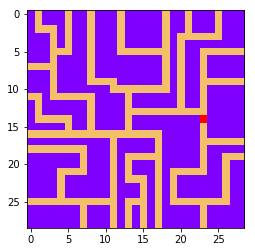

PASAJEROS RESTANTES: 39 	 TURNO: 106


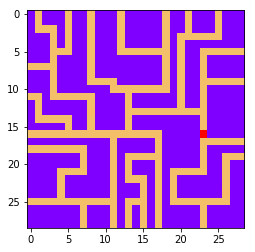

PASAJEROS RESTANTES: 39 	 TURNO: 107


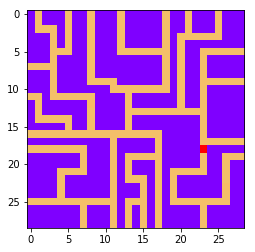

PASAJEROS RESTANTES: 39 	 TURNO: 108


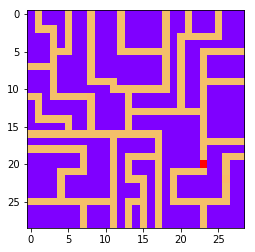

PASAJEROS RESTANTES: 39 	 TURNO: 109


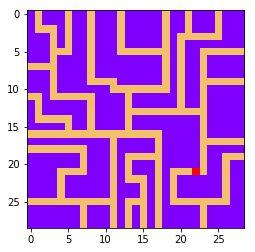

PASAJEROS RESTANTES: 39 	 TURNO: 110


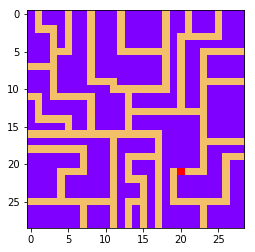

PASAJEROS RESTANTES: 39 	 TURNO: 111


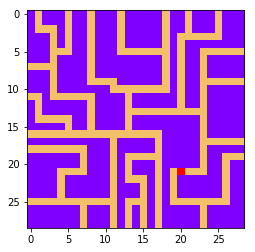

PASAJEROS RESTANTES: 39 	 TURNO: 112


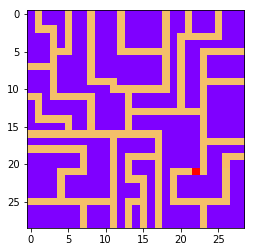

PASAJEROS RESTANTES: 39 	 TURNO: 113


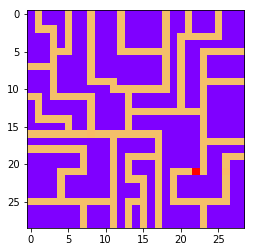

PASAJEROS RESTANTES: 39 	 TURNO: 114


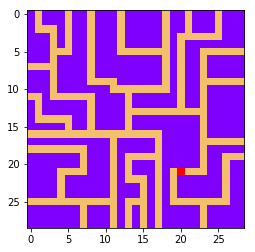

PASAJEROS RESTANTES: 39 	 TURNO: 115


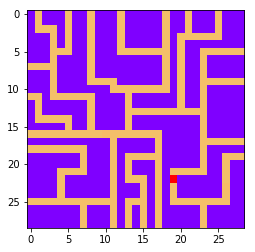

PASAJEROS RESTANTES: 39 	 TURNO: 116


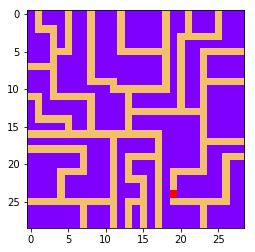

PASAJEROS RESTANTES: 39 	 TURNO: 117


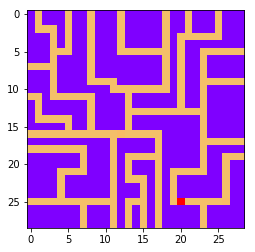

PASAJEROS RESTANTES: 39 	 TURNO: 118


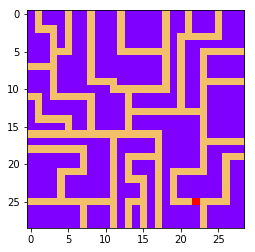

PASAJEROS RESTANTES: 39 	 TURNO: 119


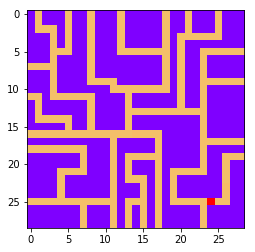

PASAJEROS RESTANTES: 39 	 TURNO: 120


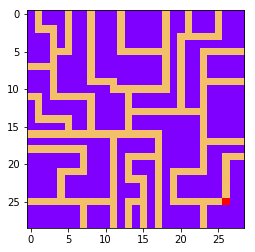

PASAJEROS RESTANTES: 39 	 TURNO: 121


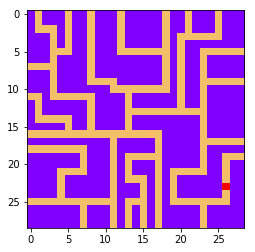

PASAJEROS RESTANTES: 39 	 TURNO: 122


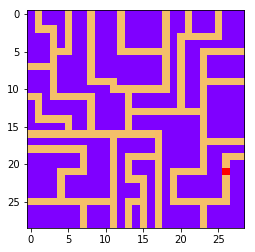

PASAJEROS RESTANTES: 39 	 TURNO: 123


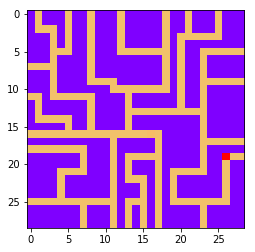

PASAJEROS RESTANTES: 2 	 TURNO: 124


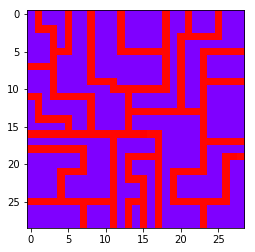

PASAJEROS RESTANTES: 1 	 TURNO: 125


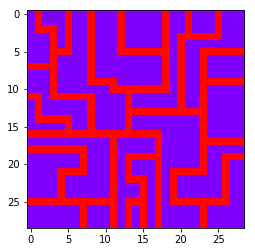

PASAJEROS RESTANTES: 1 	 TURNO: 126


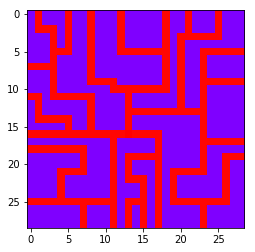

PASAJEROS RESTANTES: 1 	 TURNO: 127


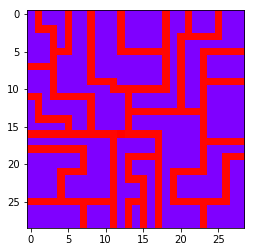

PASAJEROS RESTANTES: 1 	 TURNO: 128


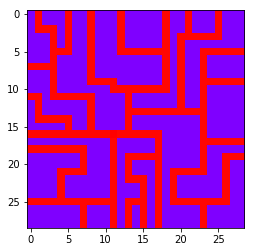

PASAJEROS RESTANTES: 1 	 TURNO: 129


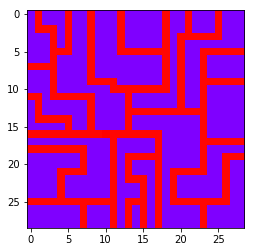

PASAJEROS RESTANTES: 1 	 TURNO: 130


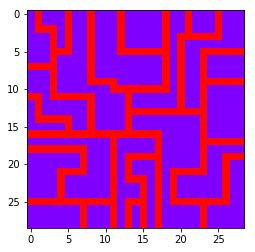

PASAJEROS RESTANTES: 1 	 TURNO: 131


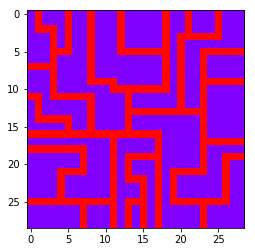

PASAJEROS RESTANTES: 1 	 TURNO: 132


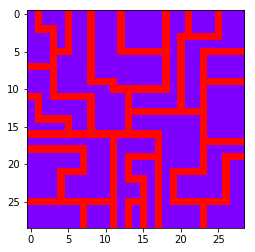

PASAJEROS RESTANTES: 1 	 TURNO: 133


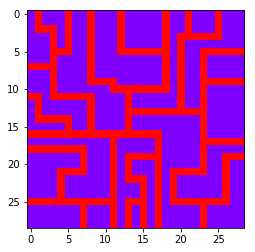

PASAJEROS RESTANTES: 1 	 TURNO: 134


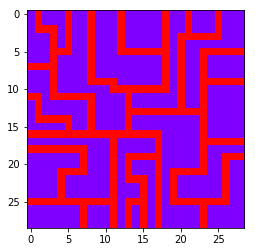

PASAJEROS RESTANTES: 1 	 TURNO: 135


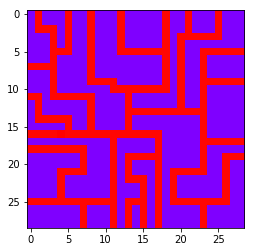

PASAJEROS RESTANTES: 1 	 TURNO: 136


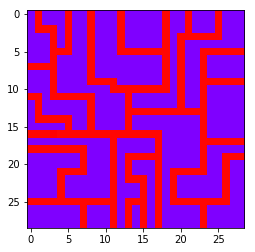

PASAJEROS RESTANTES: 1 	 TURNO: 137


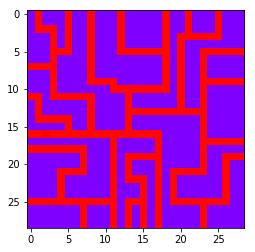

PASAJEROS RESTANTES: 1 	 TURNO: 138


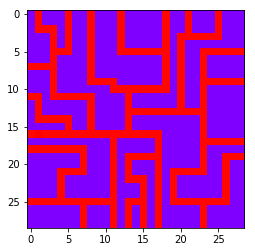

SIMULACION TERMINADA EN 138 ITERACIONES


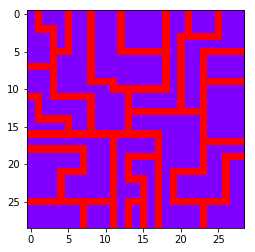

In [2]:
def main():
    simulacion = Simulacion()
    simulacion.simular()
main()